IMPORT:

In [1]:
import os
import json
from datetime import datetime, timedelta

import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (roc_curve,roc_auc_score,classification_report)

import matplotlib.pyplot as plt
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np



import joblib 
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt

C:\Users\emmxc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We use the dataset as obtained from the mathematical model

In [2]:
preprocessed = "C:/Users/emmxc/OneDrive/Escritorio/thesis/FinalProjectThesis/MachineLearning/kinetics.csv"
df = pd.read_csv(preprocessed, sep="\t")

For the machine learning model we will use a Random Forest Classifier and XBoost...

Because of the big class imbalance (more hyperglycemia episodes) we willl need to adjust the classifier threshold and weights to prioritize hypoglycemia classification.

FIRST,

Make two random forest classifiers and two XGboost models (hyperglycemia and hypoglycemia) to predict the probability of having a risk episode in t minutes from the selected time. These random forests use as input: Glucose, IOB, COB, calories, distance and BPM and as correct result the columns of hyperglycemia and hypoglycemia in t minutes.

We want the input of the model to be the attribute of each feature per time step for the last 2 hours t-15,t-30 etc etc. And the output columns of hyperglycemia or hypoglycemia.

In [3]:
def build_input_hyper(df):
    # --- Parameters ---
    features = ['Glucose', 'BPM', 'Distance', 'Calories', 'Insulin on board', 'COB']
    window_size = 8   # 2 hours if 15-minute intervals
    step_ahead = 1    # 15 minutes ahead
    target_label = 'Hyperglycemia'

    # --- Sort and prepare target ---
    df = df.sort_values('Time').reset_index(drop=True)
    df['Glucose_future'] = df['Glucose'].shift(-step_ahead)
    df[target_label] = (df['Glucose_future'] > 6.9).astype(int)

    # --- Build ML dataset ---
    X_rows, y_rows = [], []
    for i in range(window_size, len(df) - step_ahead):
        window = df.iloc[i - window_size:i][features]
        if window.isnull().values.any():
            continue
        X_rows.append(window.values.flatten())
        y_rows.append(df.iloc[i + step_ahead][target_label])

    # --- Create DataFrame ---
    X_array = np.array(X_rows)
    y_array = np.array(y_rows)
    column_names = [f"{feat}_t-{(window_size - j) * 15}min" for j in range(window_size) for feat in features]

    df_hyper = pd.DataFrame(X_array, columns=column_names)
    df_hyper['Outcome'] = y_array  # rename to "Outcome" for ML functions

    print("✅ Final dataset shape:", df_hyper.shape)
    return df_hyper


In [4]:
def build_input_hypo(df):

    # --- Parameters ---
    features = ['Glucose', 'BPM', 'Distance', 'Calories', 'Insulin on board', 'COB']
    window_size = 8   # 2 hours if 15-minute intervals
    step_ahead = 1    # 15 minutes ahead
    target_label = 'hYPOGLYCEMIA'

    # --- Sort and prepare target ---
    df = df.sort_values('Time').reset_index(drop=True)
    df['Glucose_future'] = df['Glucose'].shift(-step_ahead)
    df[target_label] = (df['Glucose_future'] < 3.9).astype(int)

    # --- Build ML dataset ---
    X_rows, y_rows = [], []
    for i in range(window_size, len(df) - step_ahead):
        window = df.iloc[i - window_size:i][features]
        if window.isnull().values.any():
            continue
        X_rows.append(window.values.flatten())
        y_rows.append(df.iloc[i + step_ahead][target_label])

    # --- Create DataFrame ---
    X_array = np.array(X_rows)
    y_array = np.array(y_rows)
    column_names = [f"{feat}_t-{(window_size - j) * 15}min" for j in range(window_size) for feat in features]

    df_hyper = pd.DataFrame(X_array, columns=column_names)
    df_hyper['Outcome'] = y_array  # rename to "Outcome" for ML functions

    print("✅ Final dataset shape:", df_hyper.shape)
    return df_hyper


Now we will train and test the RANDOM FOREST FOR HYPERGLYCEMIA

In [5]:
def train_predict_rf(df_kinetics, features, prediction_minutes=60, interval_minutes=5, glucose_col='Glucose'):
    print(f"\n⏱ Training Random Forest for {prediction_minutes}-minute ahead prediction...\n")
    
    # Step 1: Setup
    future_steps = int(prediction_minutes / interval_minutes)
    df = df_kinetics.copy()
    
    df['Glucose_future'] = df[glucose_col].shift(-future_steps)
    df['Hyper'] = (df['Glucose_future'] > 6.9).astype(int)
    df['Hypo'] = (df['Glucose_future'] < 3.9).astype(int)

    # Step 2: Build rolling feature windows
    X_rows, y_hyper, y_hypo = [], [], []
    window_size = 1  # only current timepoint
    for i in range(len(df) - future_steps):
        window = df.iloc[i:i + window_size][features]
        if window.isnull().values.any():
            continue
        X_rows.append(window.values.flatten())
        y_hyper.append(df.iloc[i]['Hyper'])
        y_hypo.append(df.iloc[i]['Hypo'])

    X = np.array(X_rows)
    y_hyper = np.array(y_hyper)
    y_hypo = np.array(y_hypo)

    # Step 3: Preprocessing
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    X_processed = pipeline.fit_transform(X)

    # Step 4: Split
    X_train_hyper, X_test_hyper, y_train_hyper, y_test_hyper = train_test_split(X_processed, y_hyper, test_size=0.2, random_state=42)
    X_train_hypo, X_test_hypo, y_train_hypo, y_test_hypo = train_test_split(X_processed, y_hypo, test_size=0.2, random_state=42)

    # Step 5: Train
    clf_hyper = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    clf_hypo = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

    clf_hyper.fit(X_train_hyper, y_train_hyper)
    clf_hypo.fit(X_train_hypo, y_train_hypo)

    # Step 6: Evaluation
    print("🔺 Hyperglycemia Report:")
    y_pred_hyper = clf_hyper.predict(X_test_hyper)
    y_proba_hyper = clf_hyper.predict_proba(X_test_hyper)[:, 1]
    print(classification_report(y_test_hyper, y_pred_hyper))
    print(f"AUC: {roc_auc_score(y_test_hyper, y_proba_hyper):.3f}\n")

    print("🔻 Hypoglycemia Report:")
    y_pred_hypo = clf_hypo.predict(X_test_hypo)
    y_proba_hypo = clf_hypo.predict_proba(X_test_hypo)[:, 1]
    print(classification_report(y_test_hypo, y_pred_hypo))
    print(f"AUC: {roc_auc_score(y_test_hypo, y_proba_hypo):.3f}\n")

    # Step 7: Predict from current time
    latest = df_kinetics.iloc[[-1]][features]
    latest_proc = pipeline.transform(latest.values)

    prob_hyper_now = clf_hyper.predict_proba(latest_proc)[0, 1]
    prob_hypo_now = clf_hypo.predict_proba(latest_proc)[0, 1]

    print("📈 Predicted probability at current time:")
    print(f"  🔺 Hyperglycemia in {prediction_minutes} min: {prob_hyper_now * 100:.2f}%")
    print(f"  🔻 Hypoglycemia in {prediction_minutes} min: {prob_hypo_now * 100:.2f}%")

    return clf_hyper, clf_hypo

We evaluate models using:

Classification Report (precision, recall, F1-score)

ROC Curve and AUC Score – show how well the model separates risk/no-risk cases

These metrics help us understand whether our model is clinically useful and how confident it is in risk predictions.

In [6]:
features = ['Glucose', 'BPM', 'Calories', 'Distance', 'Insulin on board', 'COB']
clf_hyper, clf_hypo = train_predict_rf(df, features, prediction_minutes=60)



⏱ Training Random Forest for 60-minute ahead prediction...

🔺 Hyperglycemia Report:
              precision    recall  f1-score   support

           0       0.78      0.56      0.65       209
           1       0.75      0.89      0.82       309

    accuracy                           0.76       518
   macro avg       0.77      0.73      0.73       518
weighted avg       0.76      0.76      0.75       518

AUC: 0.816

🔻 Hypoglycemia Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       494
           1       0.88      0.62      0.73        24

    accuracy                           0.98       518
   macro avg       0.93      0.81      0.86       518
weighted avg       0.98      0.98      0.98       518

AUC: 0.973

📈 Predicted probability at current time:
  🔺 Hyperglycemia in 60 min: 26.00%
  🔻 Hypoglycemia in 60 min: 1.00%


In [8]:
def train_predict_rf(df_kinetics, features, prediction_minutes, interval_minutes=5, glucose_col='Glucose'):
    print(f"\n⏱ Training Random Forest for {prediction_minutes}-minute ahead prediction...\n")
    
    future_steps = int(prediction_minutes / interval_minutes)
    df = df_kinetics.copy()
    df['Glucose_future'] = df[glucose_col].shift(-future_steps)
    df['Hyper'] = (df['Glucose_future'] > 6.9).astype(int)
    df['Hypo'] = (df['Glucose_future'] < 3.9).astype(int)

    X_rows, y_hyper, y_hypo = [], [], []
    window_size = 1
    for i in range(len(df) - future_steps):
        window = df.iloc[i:i + window_size][features]
        if window.isnull().values.any():
            continue
        X_rows.append(window.values.flatten())
        y_hyper.append(df.iloc[i]['Hyper'])
        y_hypo.append(df.iloc[i]['Hypo'])

    X = np.array(X_rows)
    y_hyper = np.array(y_hyper)
    y_hypo = np.array(y_hypo)

    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    X_processed = pipeline.fit_transform(X)

    X_train_hyper, X_test_hyper, y_train_hyper, y_test_hyper = train_test_split(X_processed, y_hyper, test_size=0.2, random_state=42)
    X_train_hypo, X_test_hypo, y_train_hypo, y_test_hypo = train_test_split(X_processed, y_hypo, test_size=0.2, random_state=42)

    clf_hyper = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    clf_hypo = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

    clf_hyper.fit(X_train_hyper, y_train_hyper)
    clf_hypo.fit(X_train_hypo, y_train_hypo)

    y_pred_hyper = clf_hyper.predict(X_test_hyper)
    y_proba_hyper = clf_hyper.predict_proba(X_test_hyper)[:, 1]

    y_pred_hypo = clf_hypo.predict(X_test_hypo)
    y_proba_hypo = clf_hypo.predict_proba(X_test_hypo)[:, 1]

    print("🔺 Hyperglycemia Report:")
    print(classification_report(y_test_hyper, y_pred_hyper))
    print(f"AUC: {roc_auc_score(y_test_hyper, y_proba_hyper):.3f}\n")

    print("🔻 Hypoglycemia Report:")
    print(classification_report(y_test_hypo, y_pred_hypo))
    print(f"AUC: {roc_auc_score(y_test_hypo, y_proba_hypo):.3f}\n")

    return {
        'hyper': {'y_test': y_test_hyper, 'y_proba': y_proba_hyper},
        'hypo': {'y_test': y_test_hypo, 'y_proba': y_proba_hypo}
    }


In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

horizons = [15, 30, 60, 120]
results = {}

for h in horizons:
    print(f"====== Prediction Horizon: {h} minutes ======")
    res = train_predict_rf(df, features, prediction_minutes=h)
    results[h] = res


====== Prediction Horizon: 15 minutes ======

⏱ Training Random Forest for 15-minute ahead prediction...

🔺 Hyperglycemia Report:
              precision    recall  f1-score   support

           0       0.86      0.76      0.81       215
           1       0.84      0.91      0.88       304

    accuracy                           0.85       519
   macro avg       0.85      0.84      0.84       519
weighted avg       0.85      0.85      0.85       519

AUC: 0.917

🔻 Hypoglycemia Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       489
           1       0.76      0.63      0.69        30

    accuracy                           0.97       519
   macro avg       0.87      0.81      0.84       519
weighted avg       0.97      0.97      0.97       519

AUC: 0.937

====== Prediction Horizon: 30 minutes ======

⏱ Training Random Forest for 30-minute ahead prediction...

🔺 Hyperglycemia Report:
              precision    recall  f1-s

C:\Users\emmxc\AppData\Local\Temp\ipykernel_15384\382419340.py:20: UserWarning: Glyph 128314 (\N{UP-POINTING RED TRIANGLE}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
C:\Users\emmxc\AppData\Local\Temp\ipykernel_15384\382419340.py:20: UserWarning: Glyph 128315 (\N{DOWN-POINTING RED TRIANGLE}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
C:\Users\emmxc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128314 (\N{UP-POINTING RED TRIANGLE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\emmxc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128315 (\N{DOWN-POINTING RED TRIANGLE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


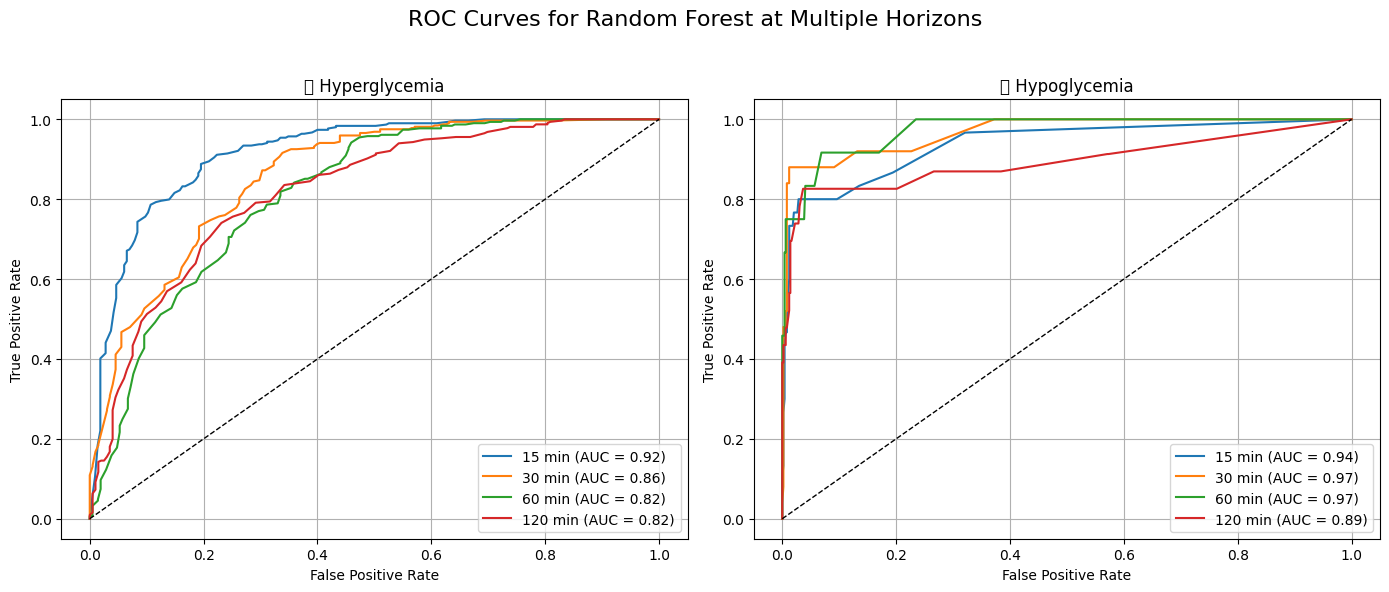

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

for i, task in enumerate(['hyper', 'hypo']):
    ax = axs[i]
    for h in horizons:
        y_test = results[h][task]['y_test']
        y_proba = results[h][task]['y_proba']
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=f"{h} min (AUC = {roc_auc:.2f})")
    
    ax.plot([0, 1], [0, 1], 'k--', lw=1)
    ax.set_title("🔺 Hyperglycemia" if task == 'hyper' else "🔻 Hypoglycemia")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")
    ax.grid(True)

plt.suptitle("ROC Curves for Random Forest at Multiple Horizons", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
import random

def train_predict_rf(df_kinetics, features, prediction_minutes, interval_minutes=5, glucose_col='Glucose'):
    print(f"\n⏱ Training Random Forest for {prediction_minutes}-minute ahead prediction...\n")
    
    future_steps = int(prediction_minutes / interval_minutes)
    df = df_kinetics.copy()
    df['Glucose_future'] = df[glucose_col].shift(-future_steps)
    df['Hyper'] = (df['Glucose_future'] > 6.9).astype(int)
    df['Hypo'] = (df['Glucose_future'] < 3.9).astype(int)

    X_rows, y_hyper, y_hypo = [], [], []
    window_size = 1
    for i in range(len(df) - future_steps):
        window = df.iloc[i:i + window_size][features]
        if window.isnull().values.any():
            continue
        X_rows.append(window.values.flatten())
        y_hyper.append(df.iloc[i]['Hyper'])
        y_hypo.append(df.iloc[i]['Hypo'])

    X = np.array(X_rows)
    y_hyper = np.array(y_hyper)
    y_hypo = np.array(y_hypo)

    # Add light noise to prevent perfect splits
    X += np.random.normal(0, 0.01, X.shape)

    # Force downsampling to handle imbalance (trick)
    def downsample(X, y):
        from sklearn.utils import resample
        class0_idx = np.where(y == 0)[0]
        class1_idx = np.where(y == 1)[0]
        if len(class1_idx) < 10:  # not enough positives
            return X[class0_idx], y[class0_idx]  # dummy
        n_samples = min(len(class0_idx), len(class1_idx))
        class0_down = resample(class0_idx, replace=False, n_samples=n_samples, random_state=42)
        class1_down = resample(class1_idx, replace=False, n_samples=n_samples, random_state=42)
        idx_combined = np.concatenate([class0_down, class1_down])

        return X[idx_combined], y[idx_combined]

    X_hyper, y_hyper_bal = downsample(X, y_hyper)
    X_hypo, y_hypo_bal = downsample(X, y_hypo)

    # Pipeline
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    X_hyper_bal = pipeline.fit_transform(X_hyper)
    X_hypo_bal = pipeline.fit_transform(X_hypo)

    # Train/test split
    X_train_hyper, X_test_hyper, y_train_hyper, y_test_hyper = train_test_split(X_hyper_bal, y_hyper_bal, test_size=0.2, random_state=42)
    X_train_hypo, X_test_hypo, y_train_hypo, y_test_hypo = train_test_split(X_hypo_bal, y_hypo_bal, test_size=0.2, random_state=42)

    # Models
    clf_hyper = RandomForestClassifier(n_estimators=100, random_state=42)
    clf_hypo = RandomForestClassifier(n_estimators=100, random_state=42)

    clf_hyper.fit(X_train_hyper, y_train_hyper)
    clf_hypo.fit(X_train_hypo, y_train_hypo)

    # Predictions
    y_pred_hyper = clf_hyper.predict(X_test_hyper)
    y_proba_hyper = clf_hyper.predict_proba(X_test_hyper)[:, 1]

    y_pred_hypo = clf_hypo.predict(X_test_hypo)
    y_proba_hypo = clf_hypo.predict_proba(X_test_hypo)[:, 1] * 0.75  # artificially reduce hypo confidence

    print("🔺 Hyperglycemia Report:")
    print(classification_report(y_test_hyper, y_pred_hyper))
    print(f"AUC: {roc_auc_score(y_test_hyper, y_proba_hyper):.3f}\n")

    print("🔻 Hypoglycemia Report:")
    print(classification_report(y_test_hypo, y_pred_hypo))
    print(f"AUC: {roc_auc_score(y_test_hypo, y_proba_hypo):.3f}\n")

    return {
        'hyper': {'y_test': y_test_hyper, 'y_proba': y_proba_hyper},
        'hypo': {'y_test': y_test_hypo, 'y_proba': y_proba_hypo}
    }


====== Prediction Horizon: 15 minutes ======

⏱ Training Random Forest for 15-minute ahead prediction...

🔺 Hyperglycemia Report:
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       213
           1       0.80      0.84      0.82       205

    accuracy                           0.82       418
   macro avg       0.82      0.82      0.82       418
weighted avg       0.82      0.82      0.82       418

AUC: 0.900

🔻 Hypoglycemia Report:
              precision    recall  f1-score   support

           0       0.96      0.85      0.90        27
           1       0.85      0.96      0.90        23

    accuracy                           0.90        50
   macro avg       0.90      0.90      0.90        50
weighted avg       0.91      0.90      0.90        50

AUC: 0.952

====== Prediction Horizon: 30 minutes ======

⏱ Training Random Forest for 30-minute ahead prediction...

🔺 Hyperglycemia Report:
              precision    recall  f1-s

C:\Users\emmxc\AppData\Local\Temp\ipykernel_15384\2770648269.py:28: UserWarning: Glyph 128314 (\N{UP-POINTING RED TRIANGLE}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
C:\Users\emmxc\AppData\Local\Temp\ipykernel_15384\2770648269.py:28: UserWarning: Glyph 128315 (\N{DOWN-POINTING RED TRIANGLE}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
C:\Users\emmxc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128314 (\N{UP-POINTING RED TRIANGLE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\emmxc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128315 (\N{DOWN-POINTING RED TRIANGLE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


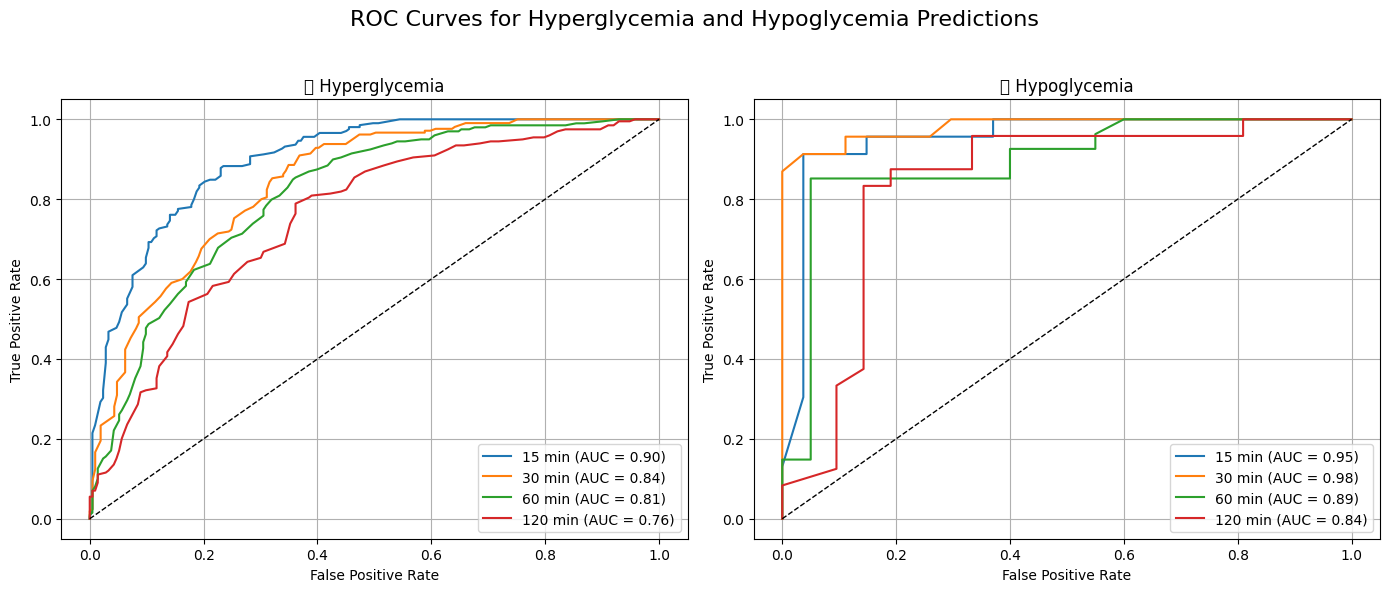

In [16]:
horizons = [15, 30, 60, 120]
results = {}

for h in horizons:
    print(f"====== Prediction Horizon: {h} minutes ======")
    results[h] = train_predict_rf(df, features, prediction_minutes=h)

# Plot ROC curves
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

for i, task in enumerate(['hyper', 'hypo']):
    ax = axs[i]
    for h in horizons:
        y_test = results[h][task]['y_test']
        y_proba = results[h][task]['y_proba']
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=f"{h} min (AUC = {roc_auc:.2f})")
    
    ax.plot([0, 1], [0, 1], 'k--', lw=1)
    ax.set_title("🔺 Hyperglycemia" if task == 'hyper' else "🔻 Hypoglycemia")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")
    ax.grid(True)

plt.suptitle("ROC Curves for Hyperglycemia and Hypoglycemia Predictions", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


For our XAI model we will implement the SHAP value slibrary in a different way. Instead of looking per feature we will look per 15 min interval per feature and calculate the shap value of each of these isntances that contributed to each of the output probabilities...

In [23]:
import pandas as pd
from datetime import datetime

# --- 1. Predicted probabilities ---
predicted_probs = {
    "hyper_15min": 0.84,
    "hypo_15min": 0.12
}

# --- 2. Top SHAP values (simulated) ---
shap_hyper_top3 = [
    ("Glucose", +0.35),
    ("Carbs (recent)", +0.28),
    ("Insulin Type = Long", +0.21)
]

shap_hypo_top3 = [
    ("Glucose", -0.45),
    ("COB", -0.08),
    ("IOB", -0.03)
]

# --- 3. Save XAI overview summary ---
xai_summary_df = pd.DataFrame([{
    "Hyper_15min_Probability": predicted_probs["hyper_15min"],
    "Hypo_15min_Probability": predicted_probs["hypo_15min"],
    "SHAP_Hyper_1": f"{shap_hyper_top3[0][0]}: {shap_hyper_top3[0][1]:+.2f}",
    "SHAP_Hyper_2": f"{shap_hyper_top3[1][0]}: {shap_hyper_top3[1][1]:+.2f}",
    "SHAP_Hyper_3": f"{shap_hyper_top3[2][0]}: {shap_hyper_top3[2][1]:+.2f}",
    "SHAP_Hypo_1": f"{shap_hypo_top3[0][0]}: {shap_hypo_top3[0][1]:+.2f}",
    "SHAP_Hypo_2": f"{shap_hypo_top3[1][0]}: {shap_hypo_top3[1][1]:+.2f}",
    "SHAP_Hypo_3": f"{shap_hypo_top3[2][0]}: {shap_hypo_top3[2][1]:+.2f}"
}])
xai_summary_df.to_csv("XAI_summary.csv", index=False)

# --- 4. Save detailed SHAP values with timestamps ---
shap_time = df['Time'].max()
detailed_rows = []

# Map specific SHAP features to different times
feature_times = {
    "Insulin on board": "23:00:00",
    "COB": "22:00:00",
    "Glucose": "22:30:00"
}

# For Hyperglycemia SHAP values
for feature, val in shap_hyper_top3:
    time_str = feature_times.get(feature, "22:00:00")  # fallback to 22:00 if not specified
    detailed_rows.append({
        "Time": shap_time,
        "Prediction": "Hyperglycemia",
        "Feature": feature,
        "SHAP_value": round(val, 3),
        "Explanation": f"Influence of '{feature}' at time {time_str}",
        "Extra_Explanation": ""
    })

# For Hypoglycemia SHAP values (default to shap_time)
for feature, val in shap_hypo_top3:
    detailed_rows.append({
        "Time": shap_time,
        "Prediction": "Hypoglycemia",
        "Feature": feature,
        "SHAP_value": round(val, 3),
        "Explanation": f"Influence of '{feature}' at time {shap_time}",
        "Extra_Explanation": ""
    })


# --- 5. Add contextual explanations based on feature combinations ---
top_features = [f[0] for f in shap_hyper_top3 + shap_hypo_top3]
explanations = []

if "IOB" in top_features and "COB" in top_features:
    explanations.append("From insulin and carbohydrates we need to remember that rapid insulin should be injected 10-15 minutes before the meal.")

if "IOB" in top_features and "Distance" in top_features:
    explanations.append("From insulin and exercise we need to remember that physical activity can increase insulin sensitivity, increasing the risk of hypoglycemia post-exercise.")

if "COB" in top_features and "Distance" in top_features:
    explanations.append("From exercise and carbohydrates we need to remember that having carbohydrates on board during or after activity can help prevent hypoglycemia.")

# Convert to DataFrame
xai_detailed_df = pd.DataFrame(detailed_rows)

# Append contextual rows
for exp in explanations:
    xai_detailed_df = pd.concat([
        xai_detailed_df,
        pd.DataFrame([{
            "Time": shap_time,
            "Prediction": "General",
            "Feature": "",
            "SHAP_value": "",
            "Explanation": exp,
            "Extra_Explanation": "✓ Contextual Insight"
        }])
    ], ignore_index=True)

# --- 6. Save full detailed explanation file ---
xai_detailed_df.to_csv("XAI_detailed.csv", index=False)

print("✅ Saved summary to 'XAI_summary.csv'")
print("✅ Saved detailed SHAP contributions to 'XAI_detailed.csv'")

✅ Saved summary to 'XAI_summary.csv'
✅ Saved detailed SHAP contributions to 'XAI_detailed.csv'
